In [1]:
import keras
keras.__version__
from pylab import *
plt.rc('font',family='Times New Roman')#全局改成Times New Roman||

D:\TAO2018\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

import os
import numpy as np
from matplotlib import pyplot as plt

fname = os.path.join( 'pollution201907_去除气压_DL.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:43801]

print(header)
print(len(lines))


#Let's convert all of these  lines of data into a Numpy array:
float_data_qian = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data_qian[i, :] = values


temp = float_data_qian[:, 1]  # 目标（标准化）
   
mean = float_data_qian[:30000].mean(axis=0)
float_data =float_data_qian- mean
std = float_data_qian[:30000].std(axis=0)
float_data = float_data/std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]   #=====
        yield samples, targets


lookback = 8             
step = 1     
delay = 2    
batch_size = 50

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=30000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=30001,
                    max_index=38000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=38001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (38000 - 30001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 38001 - lookback) // batch_size
print('测试集抽取次数：',test_steps)
print('验证集抽取次数：',val_steps)

for data_batch,labels_batch in test_gen:
    print('data_batch shape',data_batch.shape)
    print('labels_batch shape',labels_batch.shape)
    break
#print(train_gen.shape)

['date', 'dew', 'pollution', 'temp', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
43800
测试集抽取次数： 115
验证集抽取次数： 159
data_batch shape (50, 8, 7)
labels_batch shape (50,)


# 绘制污染变化情况

No handles with labels found to put in legend.


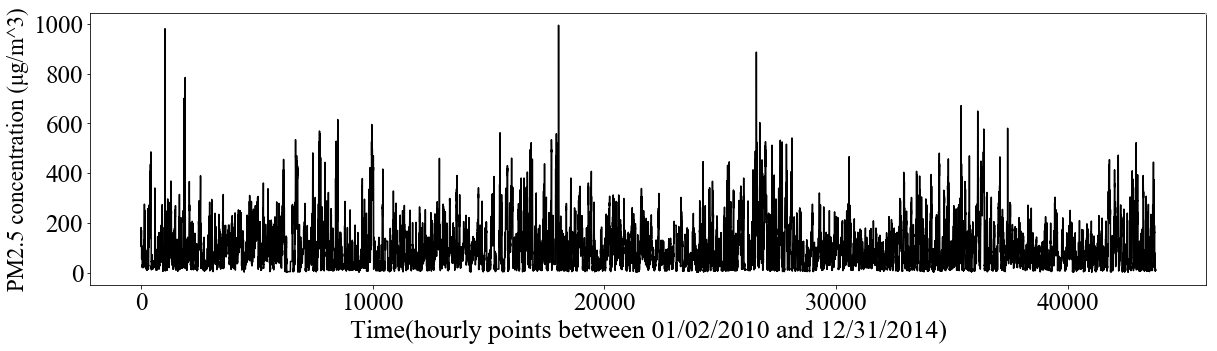

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

#调整坐标轴刻度的大小
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.plot(temp[0:], 'k')


# 设置图表标题并给坐标轴加上标签
plt.xlabel("Time(hourly points between 01/02/2010 and 12/31/2014)",fontsize=26)
plt.ylabel("PM2.5 concentration (μg/m^3)",fontsize=23)
#plt.title('True value and predicted value')

# 设置图例字体大小
plt.legend(fontsize=0)
#plt.savefig('污染变化0723.pdf', bbox_inches='tight')
plt.show()

# 建立预测模型，这里以GRU为例，可将"GRU"换成"LSTM",或全连接层

In [4]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
'''回调函数'''
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='Best.model',#============保存最佳模型
        monitor='val_loss',
        save_best_only=True,
    ),
  
    keras.callbacks.ReduceLROnPlateau(  monitor='val_loss', factor=0.1, patience=20, ),
    keras.callbacks.EarlyStopping(   #============EarlyStopping
        monitor='mse',
        patience=5,
    )
]

model = Sequential()

model.add(layers.GRU(500,dropout=0.0,recurrent_dropout=0.0,  input_shape=(None, float_data.shape[-1])))# return_sequences = True,
model.add(layers.Dropout(0.2))

model.add(layers.Dense(50))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=0.0005), loss='mae',metrics=['mse'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=600,
                              epochs=50,
                              callbacks=callbacks_list,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 500)               762000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 787,101
Trainable params: 787,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
600/600 [==============================] - 60s 100ms/step - loss: 0.3021 - mean_squared_error: 0.2626 - val_loss: 0.2860 - val_mean_squared_error: 0.2269
Epoch 2/50
  1/600 [..............................] - ETA: 1:00 - loss: 0.3701 - mean_squared_error: 0.

D:\TAO2018\Anaconda3\lib\site-packages\keras\callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


600/600 [==============================] - 60s 100ms/step - loss: 0.2829 - mean_squared_error: 0.2405 - val_loss: 0.2817 - val_mean_squared_error: 0.2103
Epoch 3/50
600/600 [==============================] - 60s 100ms/step - loss: 0.2803 - mean_squared_error: 0.2398 - val_loss: 0.2833 - val_mean_squared_error: 0.2277
Epoch 4/50
600/600 [==============================] - 56s 93ms/step - loss: 0.2745 - mean_squared_error: 0.2262 - val_loss: 0.2791 - val_mean_squared_error: 0.2175
Epoch 5/50
600/600 [==============================] - 56s 93ms/step - loss: 0.2755 - mean_squared_error: 0.2319 - val_loss: 0.2771 - val_mean_squared_error: 0.2095
Epoch 6/50
600/600 [==============================] - 56s 93ms/step - loss: 0.2739 - mean_squared_error: 0.2235 - val_loss: 0.2789 - val_mean_squared_error: 0.2145
Epoch 7/50
600/600 [==============================] - 56s 94ms/step - loss: 0.2716 - mean_squared_error: 0.2257 - val_loss: 0.2746 - val_mean_squared_error: 0.2039
Epoch 8/50
600/600 [=====

In [5]:
model.save('GRU.model')

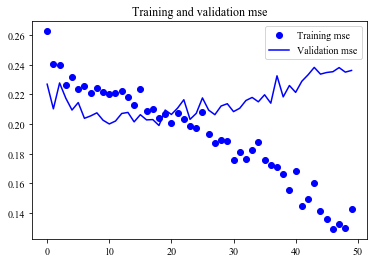

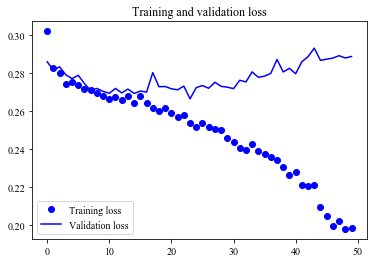

In [6]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(len(loss))
#画评价指标
plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
#画损失指标
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
 
print('01 train_mae：',history.history['loss'][-1])
print('02 val_mae：',history.history['val_loss'][-1])
print('03 train_mse：',history.history['mean_squared_error'][-1])
print('04 val_mse:',history.history['val_mean_squared_error'][-1])
test_loss,test_mse = model.evaluate_generator(test_gen, 114)
print('05 test_mae:',test_loss)
print('06 test_mse:',test_mse)
print('07 lr:',history.history['lr'][-1])
model.metrics_names   #查看评价指标的名字

#history.history #查看模型返回参数

01 train_mae： 0.19838044901688895
02 val_mae： 0.28877749378388784
03 train_mse： 0.14302485823320846
04 val_mse: 0.23616740221169386
05 test_mae: 0.23690668663434816
06 test_mse: 0.15101885238025142
07 lr: 5.0000002e-05


['loss', 'mean_squared_error']

# 预测

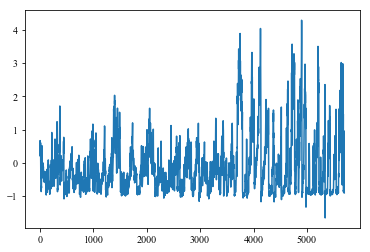

预测总长度 5700
92.52370083675247
99.22726666666667


In [4]:
from keras.models import load_model
perdict_model = load_model('Best.model')
perdict_model.summary

pre_power = perdict_model.predict_generator(test_gen, steps = 114, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
plt.plot(pre_power)
plt.show()
print('预测总长度',len(pre_power))
print(std[1])
print(mean[1])

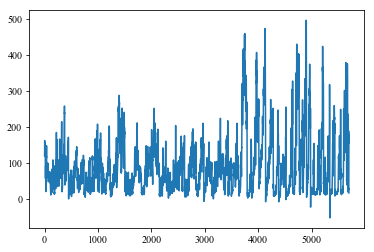

In [5]:
#***********************************还原数据******************************************#
pre_power=pre_power * std[1]
pre_power=pre_power + mean[1]
plt.plot(pre_power)
plt.show()

# 求误差 MAE MSE RMSE

In [6]:
norm_temp = float_data[:, 1]  
nttt = norm_temp[38000+68:43700+68]
ttt = temp[38000+58:43700+58]


target = ttt
prediction = pre_power

def smape(actual, predicted):
    a = np.abs(np.array(actual) - np.array(predicted))
    b = np.array(actual) + np.array(predicted)
    return 2 * np.mean(np.divide(a, b, out=np.zeros_like(a), where=b!=0, casting='unsafe'))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

error = []
for i in range(len(target)):
    error.append(target[i] - prediction[i])
  
#print("Errors: ", error)
#print(error)
  
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)#target-prediction之差平方 
    absError.append(abs(val))#误差绝对值
 
#print("Square Error: ", squaredError)
#print("Absolute Value of Error: ", absError)
 
print("MSE = ", sum(squaredError) / len(squaredError))#均方误差MSE
 
 
from math import sqrt
print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#均方根误差RMSE
print("MAE = ", sum(absError) / len(absError))#平均绝对误差MAE

print("MAPE = ", mean_absolute_percentage_error(target, prediction))#平均绝对误差MAE
print("SMAPE = ", smape(target, prediction))#平均绝对误差MAE

MSE =  187.63765350877193
RMSE =  13.698089410891285
MAE =  9.163796600877193
MAPE =  248.57266082919455
SMAPE =  0.90990400423927


In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAPE = ", mean_absolute_percentage_error(target, prediction))#平均绝对误差MAE

# 函数：计算相关系数
def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b) 
    # 计算分子，协方差————按照协方差公式，本来要除以n的，由于在相关系数中上下同时约去了n，于是可以不除以n
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
    # 计算分母，方差乘积————方差本来也要除以n，在相关系数中上下同时约去了n，于是可以不除以n
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b])) 
    corr_factor = cov_ab/sq
    #return corr_factor
    print(corr_factor)

#http://www.itdaan.com/blog/2018/05/03/4ba16144b1f1e3177afbfa180690e9b2.html    
# 计算相关度
def computeCorrelation(x,y):
    xBar = np.mean(x)
    yBar = np.mean(y)
    SSR = 0.0
    varX = 0.0
    varY = 0.0
    for i in range(0,len(x)):
        diffXXbar = x[i] - xBar
        difYYbar = y[i] - yBar
        SSR += (diffXXbar * difYYbar)
        varX += diffXXbar**2
        varY += difYYbar**2
    SST = math.sqrt(varX * varY)
    return SSR/SST

# 计算R平方
def polyfit(x,y,degree):
    results = {}
    coeffs = np.polyfit(x,y,degree)
    results['polynomial'] = coeffs.tolist()
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat - ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['determination'] = ssreg/sstot
    return results

print('lstm:')
calc_corr(target, prediction)

MAPE =  248.57266082919455
lstm:
0.9868509409913497


# 画散点图

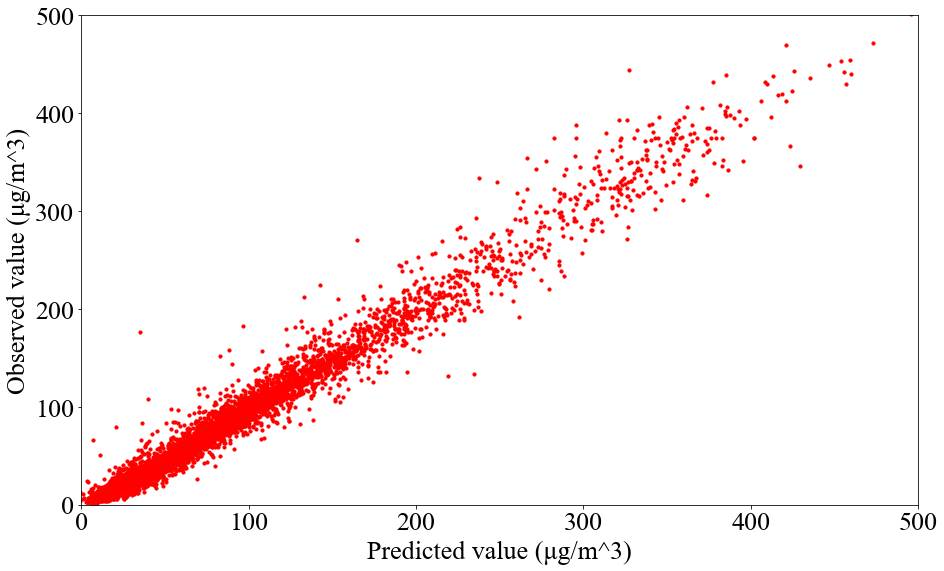

In [8]:
import matplotlib.pyplot as plt

# s为点的大小
#plt.scatter(x_values,y_values,s=100)
plt.figure(figsize=(15,9))

plt.xlim(xmax=500,xmin=0)
plt.ylim(ymax=500,ymin=0)

plt.scatter(prediction,ttt,s=10,c='r')
#ttt
# 设置图表标题并给坐标轴加上标签
#plt.title("GRU",fontsize=24)
plt.xlabel("Predicted value (μg/m^3)",fontsize=26)
plt.ylabel("Observed value (μg/m^3)",fontsize=26)

# 设置刻度标记的大小
plt.tick_params(axis='both',which='major',labelsize=26)

plt.show()

In [ ]:
import numpy  
numpy.savetxt('PM25预测真实值.csv', ttt, delimiter = ',')  #注意，由于这里预测的是两个小时后的数据 真实值是从35800+58+2开始的

In [ ]:
import numpy  
numpy.savetxt('PM25预测结果GRU.csv', pre_power, delimiter = ',')

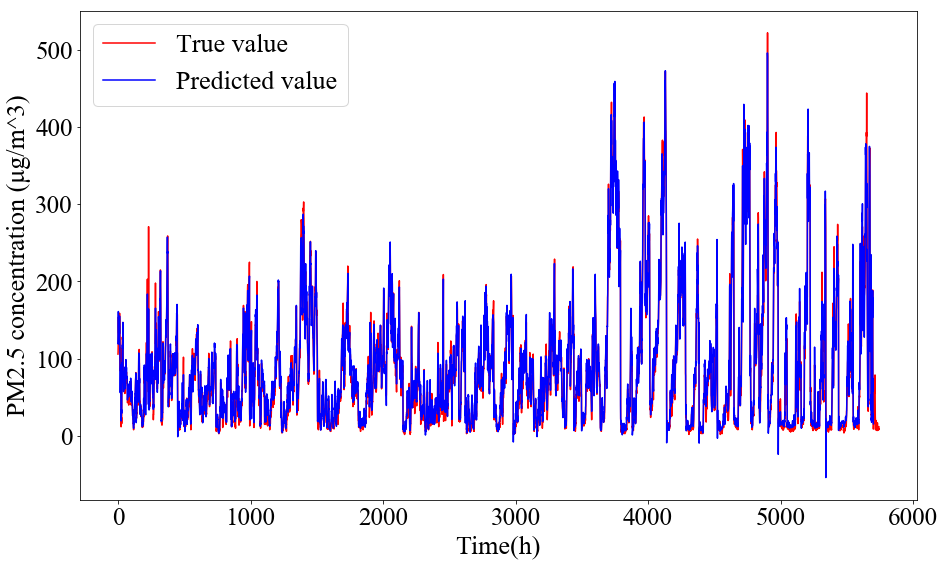

In [9]:
import matplotlib.pyplot as plt

steps = range(len(pre_power))

plt.figure(figsize=(15,9))

#调整坐标轴刻度的大小
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.plot(temp[38000+58:], 'r', label='True value')
plt.plot(pre_power, 'b', label='Predicted value')
#plt.plot(range(5760), temp[38000:43760], 'r', label='True value')
#plt.plot(pre_power, 'b', label='predicted value')

# 设置图表标题并给坐标轴加上标签
plt.xlabel("Time(h)",fontsize=26)
plt.ylabel("PM2.5 concentration (μg/m^3)",fontsize=26)
#plt.title('True value and predicted value')

# 设置图例字体大小
plt.legend(fontsize=26)

plt.show()